# Análisis Exploratorio de Datos (EDA) - Groceries E-commerce


Este notebook contiene el análisis exploratorio inicial de los datos de una plataforma de e-commerce de alimentación.

## Configuración Inicial


In [100]:
# Imports necesarios
import os
import boto3
from dotenv import load_dotenv
import pathlib
import pandas as pd
import fastparquet as fp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from typing import Optional, Tuple, List, Dict, Any
import calendar
from itertools import chain
from collections import Counter

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Cargar variables de entorno
load_dotenv()
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
S3_PATH = "s3://zrive-ds-data/groceries/sampled-datasets/"
LOCAL_DATA_PATH = 'groceries_data/'

## 1. Carga de Datos

In [101]:
def download_grocery_data(aws_url: str, local_path: str) -> None:
    """Descarga datos de S3 si no existen localmente."""
    pathlib.Path(local_path).mkdir(parents=True, exist_ok=True)
    
    s3 = boto3.client('s3',
                     aws_access_key_id=AWS_ACCESS_KEY_ID,
                     aws_secret_access_key=AWS_SECRET_ACCESS_KEY)
    
    bucket_name = aws_url.split('/')[2]
    prefix = '/'.join(aws_url.split('/')[3:])
    
    try:
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
        if 'Contents' not in response:
            print("No se encontraron archivos en S3")
            return
            
        for obj in response['Contents']:
            file_key = obj['Key']
            file_name = os.path.basename(file_key)
            local_file_path = os.path.join(local_path, file_name)
            
            print(f"Descargando {file_key} a {local_file_path}")
            s3.download_file(bucket_name, file_key, local_file_path)
    except Exception as e:
        print(f"Error al descargar: {e}")

def get_grocery_file(file: str = 'orders.parquet') -> pd.DataFrame:
    """Obtiene archivo de datos, descargándolo si es necesario."""
    file_path = os.path.join(LOCAL_DATA_PATH, file)
    
    if not os.path.isfile(file_path):
        download_grocery_data(S3_PATH, LOCAL_DATA_PATH)
    else:
        print(f"Archivo {file} ya existe localmente.")
        
    return pd.read_parquet(file_path, engine='fastparquet')

# Cargar todos los datasets
datasets = ['orders.parquet', 'regulars.parquet', 'abandoned_carts.parquet', 
           'inventory.parquet', 'users.parquet']

dfs = {}
for dataset in datasets:
    dfs[dataset.split('.')[0]] = get_grocery_file(dataset)
    
orders_df = dfs['orders']
regulars_df = dfs['regulars']
abandoned_carts_df = dfs['abandoned_carts']
inventory_df = dfs['inventory']
users_df = dfs['users']

Archivo orders.parquet ya existe localmente.
Archivo regulars.parquet ya existe localmente.
Archivo abandoned_carts.parquet ya existe localmente.
Archivo inventory.parquet ya existe localmente.
Archivo users.parquet ya existe localmente.


## 2. Exploración de Datos

### 2.1. Visión General de los Datasets

In [102]:
# Dimensiones y columnas de cada dataset
for name, df in dfs.items():
    print(f"\n{name.upper()}")
    print(f"Dimensiones: {df.shape}")
    print(f"Columnas: {', '.join(df.columns)}")
    print("-" * 50)


ORDERS
Dimensiones: (8773, 6)
Columnas: id, user_id, created_at, order_date, user_order_seq, ordered_items
--------------------------------------------------

REGULARS
Dimensiones: (18105, 3)
Columnas: user_id, variant_id, created_at
--------------------------------------------------

ABANDONED_CARTS
Dimensiones: (5457, 4)
Columnas: id, user_id, created_at, variant_id
--------------------------------------------------

INVENTORY
Dimensiones: (1733, 6)
Columnas: variant_id, price, compare_at_price, vendor, product_type, tags
--------------------------------------------------

USERS
Dimensiones: (4983, 10)
Columnas: user_id, user_segment, user_nuts1, first_ordered_at, customer_cohort_month, count_people, count_adults, count_children, count_babies, count_pets
--------------------------------------------------


## 2.2. Análisis de IDs de Items

Un aspecto importante es entender la relación entre los item_id (en orders) y variant_id (en inventory). Tras investigar, determiné que son conceptos equivalentes - representan la misma entidad de producto.

In [103]:
all_ordered_items = list(chain.from_iterable(orders_df['ordered_items']))
ordered_item_ids = set(all_ordered_items)

inventory_item_ids = set(inventory_df['variant_id'])

print(f"Items únicos en orders: {len(ordered_item_ids):,}")
print(f"Items únicos en inventory: {len(inventory_item_ids):,}")

missing_items = ordered_item_ids - inventory_item_ids
print(f"Items en orders sin información en inventory: {len(missing_items):,}")
print(f"Porcentaje de items sin info: {len(missing_items)/len(ordered_item_ids)*100:.1f}%")

Items únicos en orders: 2,117
Items únicos en inventory: 1,733
Items en orders sin información en inventory: 640
Porcentaje de items sin info: 30.2%


## 2.3. Análisis de Pedidos


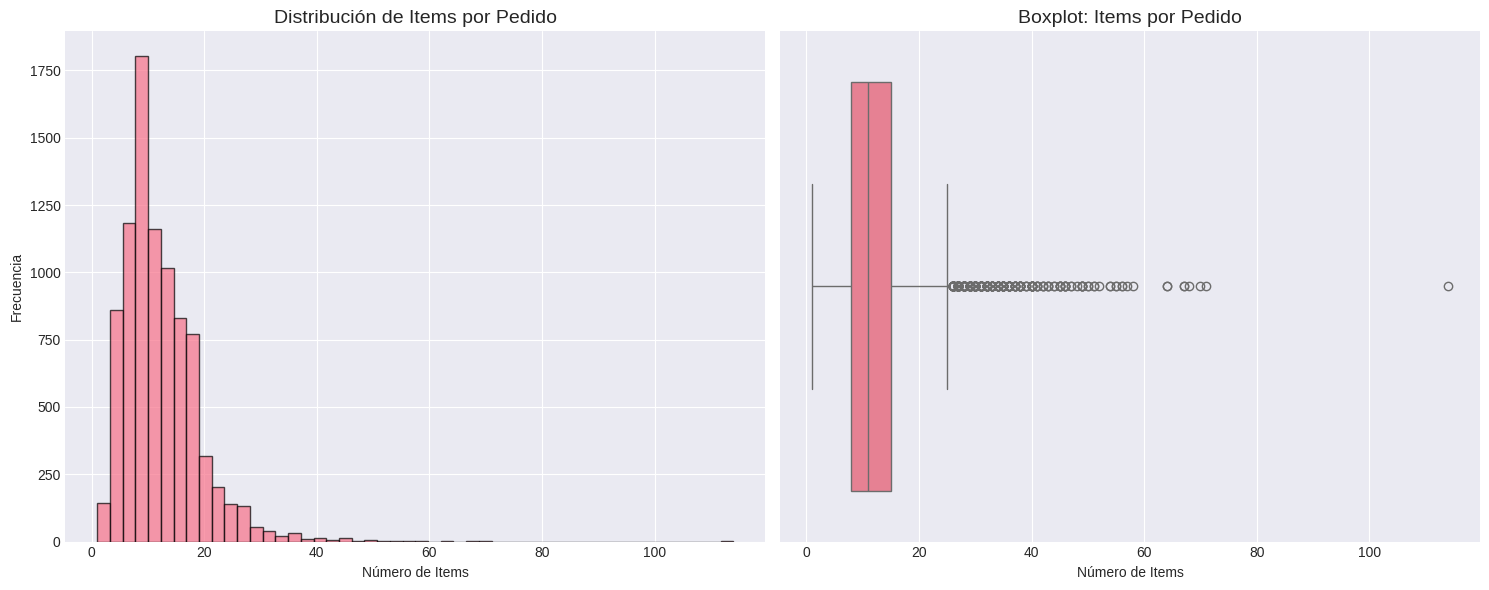


Estadísticas de items por pedido:
count    8773.000000
mean       12.305711
std         6.839507
min         1.000000
25%         8.000000
50%        11.000000
75%        15.000000
max       114.000000
Name: num_items, dtype: float64


In [104]:
# Añadir columna con número de items por pedido
orders_df['num_items'] = orders_df['ordered_items'].apply(len)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histograma
ax1.hist(orders_df['num_items'], bins=50, edgecolor='black', alpha=0.7)
ax1.set_title('Distribución de Items por Pedido', fontsize=14)
ax1.set_xlabel('Número de Items')
ax1.set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(data=orders_df, x='num_items', ax=ax2)
ax2.set_title('Boxplot: Items por Pedido', fontsize=14)
ax2.set_xlabel('Número de Items')

plt.tight_layout()
plt.show()

print("\nEstadísticas de items por pedido:")
print(orders_df['num_items'].describe())

## 2.4. Patrones Temporales


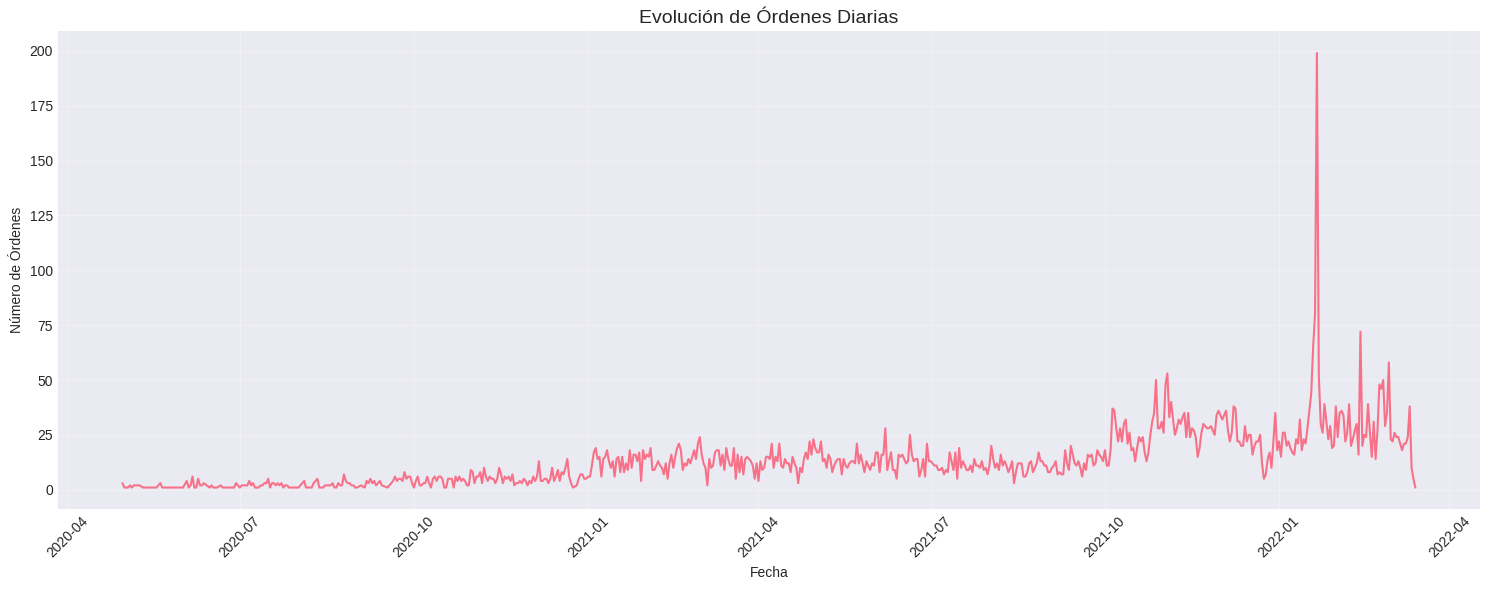


Día con más órdenes: 2022-01-21 (199 órdenes)


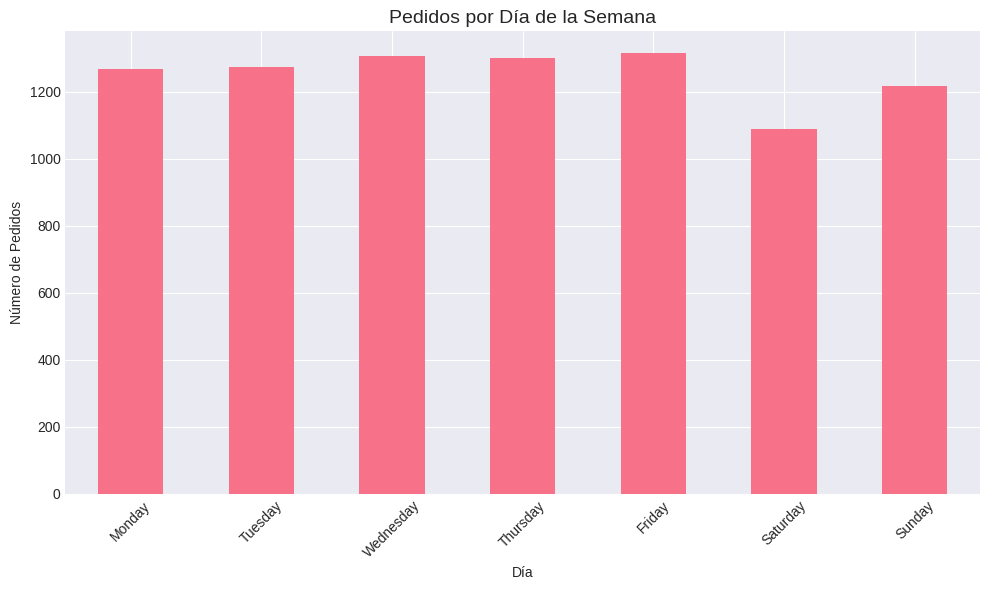

In [105]:
# Órdenes por día
orders_per_day = orders_df.groupby('order_date').size()

# Visualización de serie temporal
plt.figure(figsize=(15, 6))
plt.plot(orders_per_day.index, orders_per_day.values, linewidth=1.5)
plt.title('Evolución de Órdenes Diarias', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Número de Órdenes')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identificar día con más órdenes
max_day = orders_per_day.idxmax()
print(f"\nDía con más órdenes: {max_day.date()} ({orders_per_day.max()} órdenes)")

# Análisis por día de la semana
orders_df['weekday'] = pd.to_datetime(orders_df['order_date']).dt.day_name()
weekday_counts = orders_df['weekday'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

plt.figure(figsize=(10, 6))
weekday_counts.plot(kind='bar')
plt.title('Pedidos por Día de la Semana', fontsize=14)
plt.xlabel('Día')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2.5. Análisis de Inventario


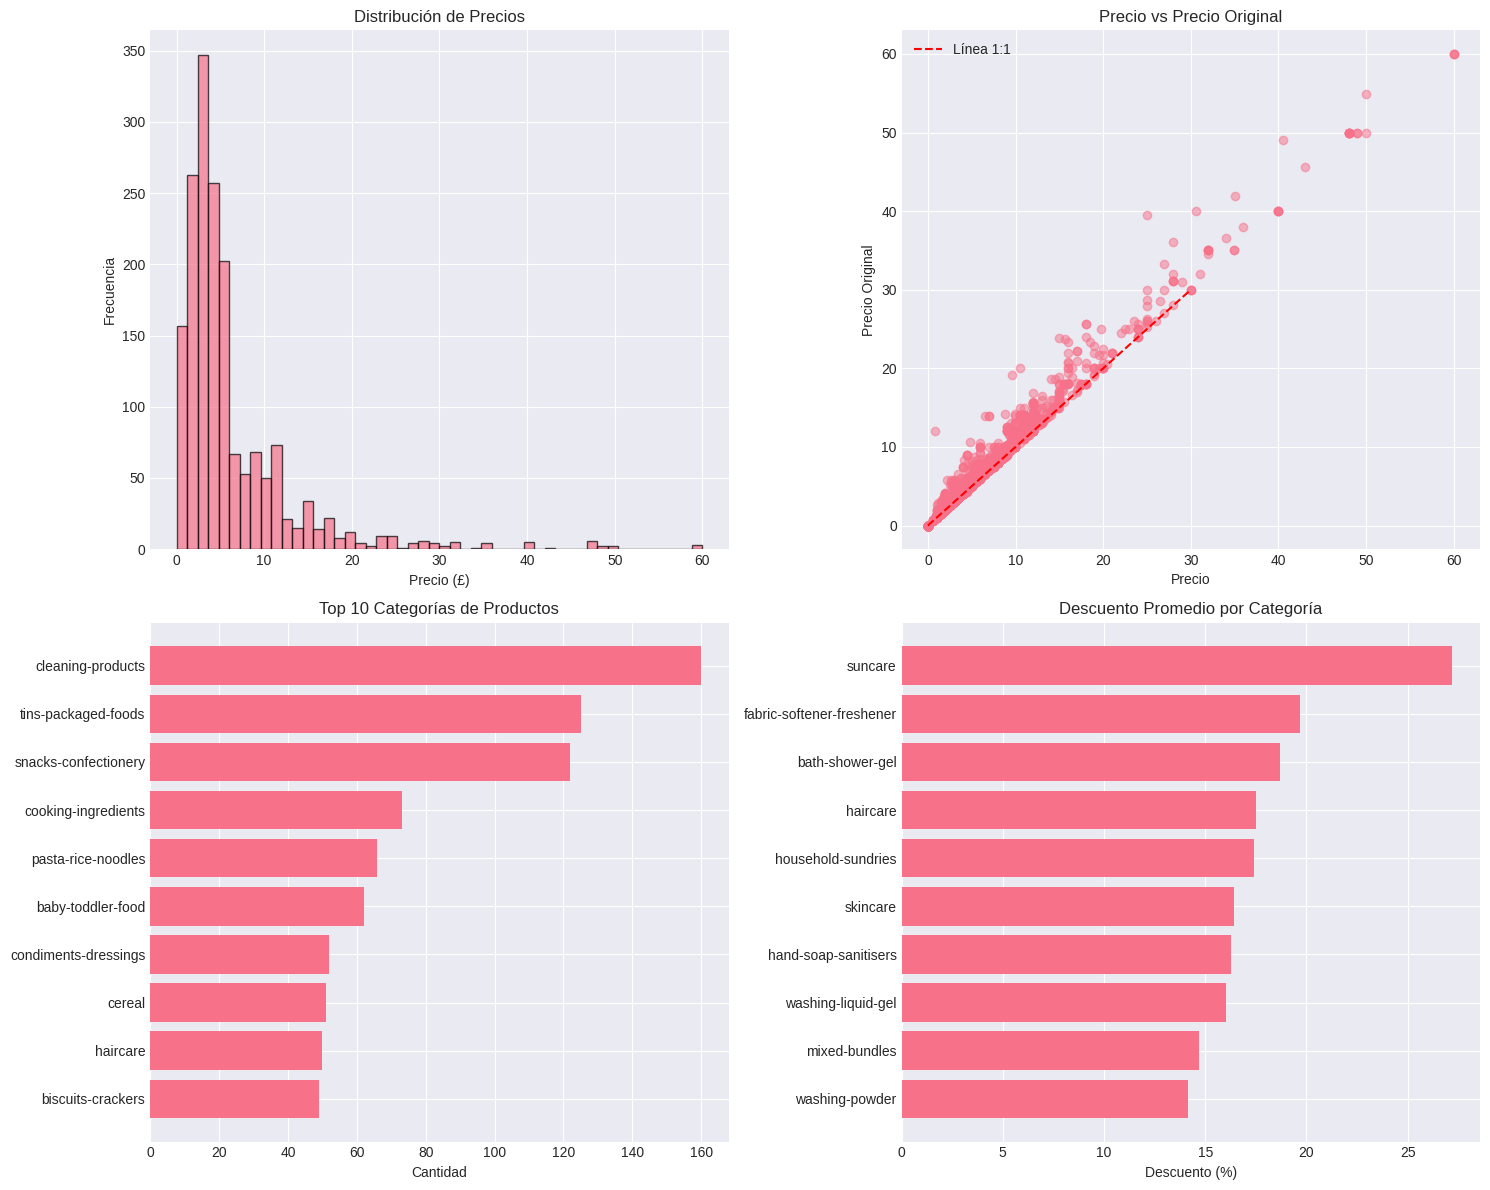

In [106]:
# Estadísticas de precios
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribución de precios
axes[0,0].hist(inventory_df['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Distribución de Precios')
axes[0,0].set_xlabel('Precio (£)')
axes[0,0].set_ylabel('Frecuencia')

# Relación precio vs precio comparado
axes[0,1].scatter(inventory_df['price'], inventory_df['compare_at_price'], alpha=0.5)
axes[0,1].plot([0, 30], [0, 30], 'r--', label='Línea 1:1')
axes[0,1].set_xlabel('Precio')
axes[0,1].set_ylabel('Precio Original')
axes[0,1].set_title('Precio vs Precio Original')
axes[0,1].legend()

# Categorías más comunes
top_categories = inventory_df['product_type'].value_counts().head(10)
axes[1,0].barh(top_categories.index[::-1], top_categories.values[::-1])
axes[1,0].set_title('Top 10 Categorías de Productos')
axes[1,0].set_xlabel('Cantidad')

# Descuentos por categoría
inventory_df['discount_percent'] = np.where(
    (inventory_df['compare_at_price'] > 0) & (inventory_df['price'] > 0),
    ((inventory_df['compare_at_price'] - inventory_df['price']) / inventory_df['compare_at_price']) * 100,
    0
)

category_discounts = inventory_df.groupby('product_type')['discount_percent'].mean().sort_values(ascending=False).head(10)
axes[1,1].barh(category_discounts.index[::-1], category_discounts.values[::-1])
axes[1,1].set_title('Descuento Promedio por Categoría')
axes[1,1].set_xlabel('Descuento (%)')

plt.tight_layout()
plt.show()

## 2.6. Análisis de Usuarios


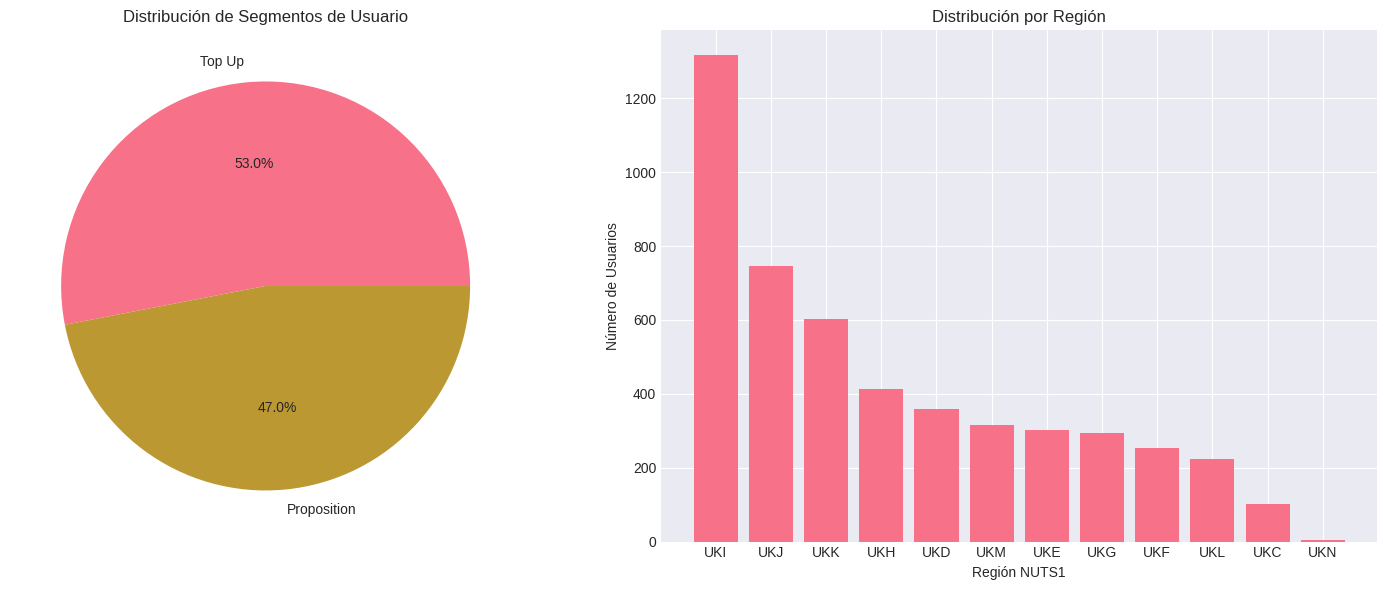


Porcentaje de valores faltantes en datos demográficos:
count_people: 93.5%
count_adults: 93.5%
count_children: 93.5%
count_babies: 93.5%
count_pets: 93.5%


In [107]:
# Distribución de segmentos de usuario
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Segmentos
segment_counts = users_df['user_segment'].value_counts()
axes[0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
axes[0].set_title('Distribución de Segmentos de Usuario')

# Regiones NUTS1
nuts1_counts = users_df['user_nuts1'].value_counts()
axes[1].bar(nuts1_counts.index, nuts1_counts.values)
axes[1].set_title('Distribución por Región')
axes[1].set_xlabel('Región NUTS1')
axes[1].set_ylabel('Número de Usuarios')

plt.tight_layout()
plt.show()

# Análisis de campos faltantes en datos demográficos
demo_columns = ['count_people', 'count_adults', 'count_children', 'count_babies', 'count_pets']
missing_pct = users_df[demo_columns].isna().mean() * 100

print("\nPorcentaje de valores faltantes en datos demográficos:")
for col, pct in missing_pct.items():
    print(f"{col}: {pct:.1f}%")

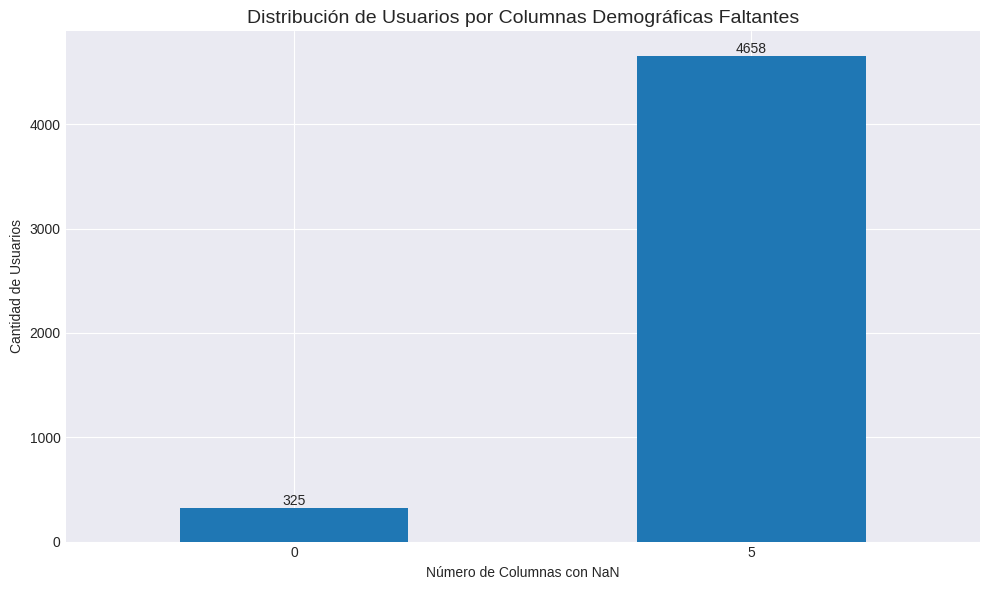


Patrón de valores faltantes en datos demográficos:
Usuarios con TODOS los campos demográficos faltantes: 4,658
Usuarios con TODOS los campos demográficos completos: 325
Usuarios con datos parciales: 0

🔍 Hallazgo importante:
Los datos demográficos siguen un patrón de 'todo o nada':
- O el usuario tiene TODOS los campos demográficos completos
- O el usuario tiene TODOS los campos demográficos vacíos (NaN)
- NO existen usuarios con datos parcialmente completados

⚠️ Implicación: La imputación de estos valores podría ser problemática
   debido a que el 93% de los usuarios no proporcionaron esta información.


In [108]:
# Análisis de patrones de valores faltantes en datos demográficos
demo_columns = ['count_people', 'count_adults', 'count_children', 'count_babies', 'count_pets']

# Contar NaNs por usuario en las columnas demográficas
users_df['nans_in_group'] = users_df[demo_columns].isna().sum(axis=1)

# Visualizar la distribución
plt.figure(figsize=(10, 6))
nans_distribution = users_df['nans_in_group'].value_counts().sort_index()
bars = nans_distribution.plot(kind='bar', color=['#1f77b4' if x in [0, 5] else '#ff7f0e' for x in nans_distribution.index])
plt.title('Distribución de Usuarios por Columnas Demográficas Faltantes', fontsize=14)
plt.xlabel('Número de Columnas con NaN')
plt.ylabel('Cantidad de Usuarios')
plt.xticks(rotation=0)

# Añadir etiquetas a las barras
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Resumen del patrón
print("\nPatrón de valores faltantes en datos demográficos:")
print(f"Usuarios con TODOS los campos demográficos faltantes: {sum(users_df['nans_in_group'] == 5):,}")
print(f"Usuarios con TODOS los campos demográficos completos: {sum(users_df['nans_in_group'] == 0):,}")  
print(f"Usuarios con datos parciales: {sum((users_df['nans_in_group'] > 0) & (users_df['nans_in_group'] < 5)):,}")

# Conclusión sobre imputación
print("\n🔍 Hallazgo importante:")
print("Los datos demográficos siguen un patrón de 'todo o nada':")
print("- O el usuario tiene TODOS los campos demográficos completos")
print("- O el usuario tiene TODOS los campos demográficos vacíos (NaN)")
print("- NO existen usuarios con datos parcialmente completados")
print("\n⚠️ Implicación: La imputación de estos valores podría ser problemática")
print("   debido a que el 93% de los usuarios no proporcionaron esta información.")

# 3. Integración de Datasets

## 3.1. Explicación de la Lógica de Join

Para crear un dataset unificado, seguimos esta lógica:

1. Explotar pedidos: Cada item pedido se convierte en una fila
2. Merge con usuarios: Añadir información demográfica
3. Merge con inventory: Añadir detalles del producto
4. Calcular campos de regulars: Cantidad de veces que un item es regular para un usuario
5. Calcular campos de abandoned_carts: Cantidad de veces que un item fue abandonado por un usuario

In [109]:
# 1. Explotar órdenes
groceries_df = orders_df.explode('ordered_items')
groceries_df = groceries_df.rename(columns={'ordered_items': 'item_id'})

# 2. Merge con usuarios
groceries_df = pd.merge(groceries_df, users_df, on='user_id', how='left')

# 3. Merge con inventory
groceries_df = pd.merge(groceries_df, inventory_df, 
                       left_on='item_id', right_on='variant_id', how='left')

# 4. Calcular campos de regulars
regulars_count = regulars_df.groupby(['user_id', 'variant_id']).size().reset_index(name='regular_count')
groceries_df = pd.merge(groceries_df, regulars_count,
                       left_on=['user_id', 'item_id'],
                       right_on=['user_id', 'variant_id'], how='left')
groceries_df['regular_count'] = groceries_df['regular_count'].fillna(0).astype(int)

# 5. Calcular campos de abandoned_carts
abandoned_items = abandoned_carts_df.explode('variant_id')
abandoned_count = abandoned_items.groupby(['user_id', 'variant_id']).size().reset_index(name='abandoned_count')
groceries_df = pd.merge(groceries_df, abandoned_count,
                       left_on=['user_id', 'item_id'],
                       right_on=['user_id', 'variant_id'], how='left')
groceries_df['abandoned_count'] = groceries_df['abandoned_count'].fillna(0).astype(int)

# Limpiar columnas duplicadas
groceries_df = groceries_df.drop(columns=['variant_id_x', 'variant_id_y', 'variant_id'])

print(f"Dataset final: {groceries_df.shape}")
print(f"Columnas disponibles: {', '.join(groceries_df.columns)}")

Dataset final: (107958, 26)
Columnas disponibles: id, user_id, created_at, order_date, user_order_seq, item_id, num_items, weekday, user_segment, user_nuts1, first_ordered_at, customer_cohort_month, count_people, count_adults, count_children, count_babies, count_pets, nans_in_group, price, compare_at_price, vendor, product_type, tags, discount_percent, regular_count, abandoned_count


# 4. Análisis Avanzados

## 4.1. Comportamiento de Compra Regular

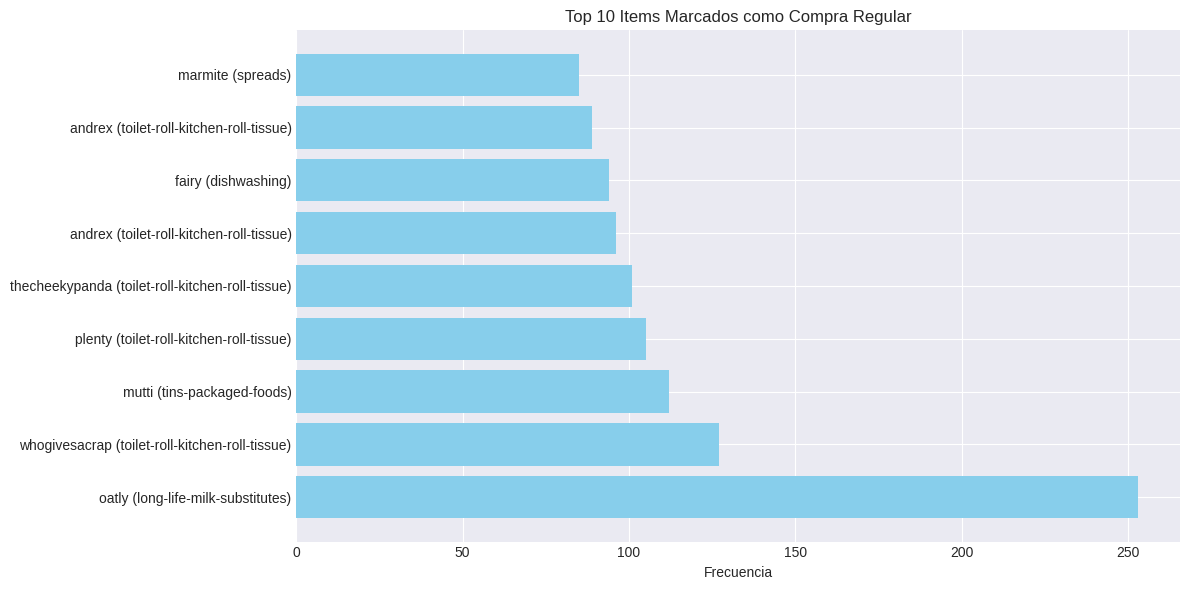

In [110]:
regulars_popularity = regulars_df['variant_id'].value_counts().head(10)

top_regulars = pd.merge(regulars_popularity.reset_index(), 
                       inventory_df[['variant_id', 'vendor', 'product_type']], 
                       on='variant_id')

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_regulars)), top_regulars['count'], color='skyblue')
plt.yticks(range(len(top_regulars)), 
           [f"{row['vendor']} ({row['product_type']})" for _, row in top_regulars.iterrows()])
plt.xlabel('Frecuencia')
plt.title('Top 10 Items Marcados como Compra Regular')
plt.tight_layout()
plt.show()

## 4.2. Patrón de Abandono de Carrito

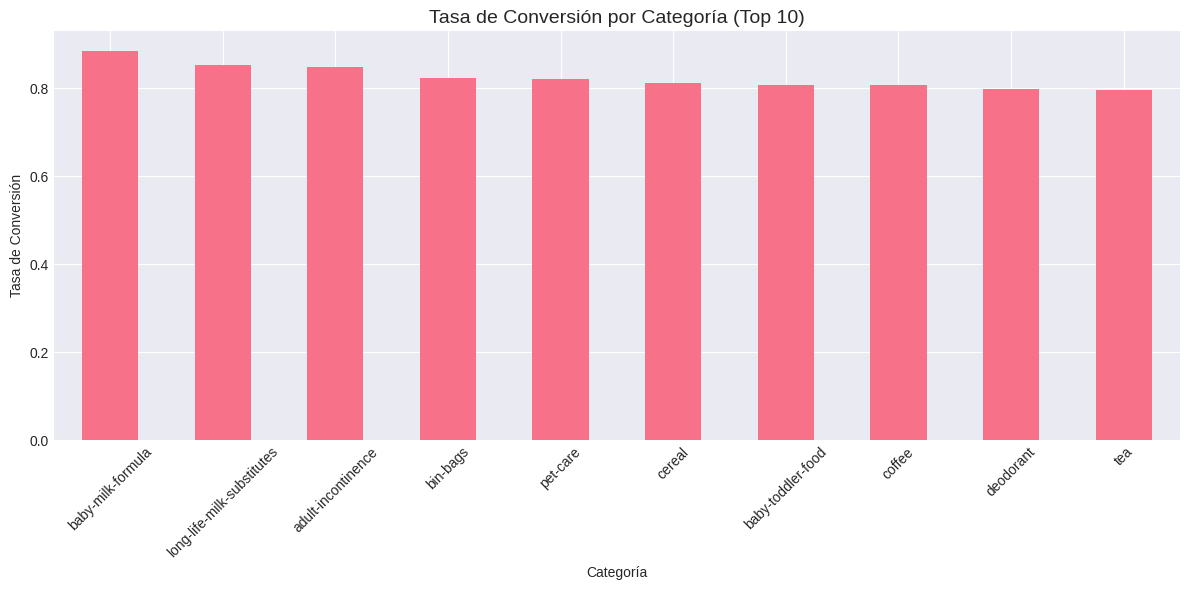

In [111]:
category_abandonment = {}

for category in inventory_df['product_type'].unique():

    category_items = inventory_df[inventory_df['product_type'] == category]['variant_id']
    
    ordered = groceries_df[groceries_df['item_id'].isin(category_items)].shape[0]
    
    abandoned_items_exploded = abandoned_carts_df.explode('variant_id')
    abandoned = abandoned_items_exploded[
        abandoned_items_exploded['variant_id'].isin(category_items)
    ].shape[0]
    
    if ordered + abandoned > 0:
        conversion_rate = ordered / (ordered + abandoned)
        category_abandonment[category] = conversion_rate

# Visualizar ratio de conversión
abandoned_df = pd.DataFrame.from_dict(category_abandonment, orient='index', columns=['conversion_rate'])
abandoned_df = abandoned_df.sort_values('conversion_rate', ascending=False).head(10)

plt.figure(figsize=(12, 6))
abandoned_df['conversion_rate'].plot(kind='bar')
plt.title('Tasa de Conversión por Categoría (Top 10)', fontsize=14)
plt.xlabel('Categoría')
plt.ylabel('Tasa de Conversión')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Resumen de Hallazgos

## Hallazgos Principales:

1. Discrepancia de Items: Hay 640 items (30.2%) en órdenes que no tienen información en inventory
2. Comportamiento de Compra:
    - Los clientes compran en promedio 12.3 items por pedido
    - Hay un pico significativo de órdenes el 21 de enero de 2022 (199 órdenes)
    - Los martes son el día más popular para realizar pedidos


3. Estructura de Precios:
    - El precio promedio es de £4.49
    - Las categorías más comunes son productos de limpieza
    - Los descuentos promedian 6.4%


4. Datos Demográficos:
    - 93.5% de usuarios no tienen datos demográficos completos
    - La mayoría de usuarios pertenecen al segmento "Top Up"
    - La distribución regional está balanceada


5. Patrones de Comportamiento:
    - Los productos de higiene personal y limpieza son los más marcados como regulares
    - La tasa de abandono varía significativamente por categoría